In [1]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
from collections import Counter
from nltk.tokenize import word_tokenize
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
import random

In [4]:
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/684folder//processed_real_data_large.csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Preparation

In [5]:
# data = pd.read_csv("synthetic_reviews.csv")
data = pd.read_csv(file_path)
data.head()

,Unnamed: 0,Age,Review Text,Rating,Recommended IND,Positive Feedback Count
0,0,37,a great little dress that can be dressed up or...,5,1,0
1,1,44,i found this in store last weekend and thought...,5,1,8
2,2,32,i bought one of these as a gift for a friend a...,5,1,0
3,3,54,"i love this tunic, the detail the weight, the ...",4,1,2
4,4,58,i got this in the color listed as pink. it is ...,5,1,3


Distribution of recommended IND, ratings and age.

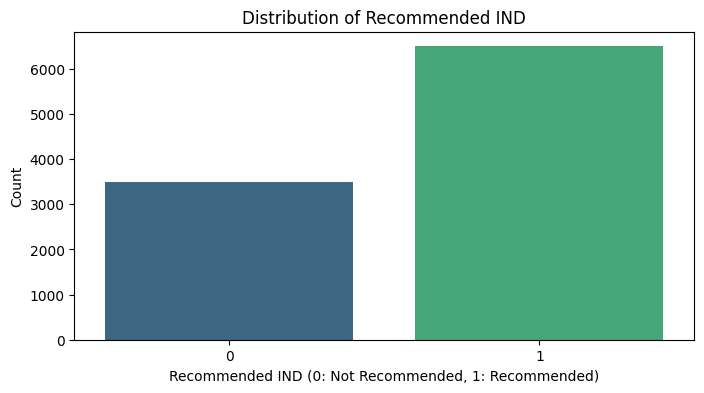

In [6]:
plt.figure(figsize=(8, 4))
sns.countplot(data=data, x="Recommended IND", hue="Recommended IND", palette="viridis", dodge=False, legend=False)
plt.title("Distribution of Recommended IND")
plt.xlabel("Recommended IND (0: Not Recommended, 1: Recommended)")
plt.ylabel("Count")
plt.show()

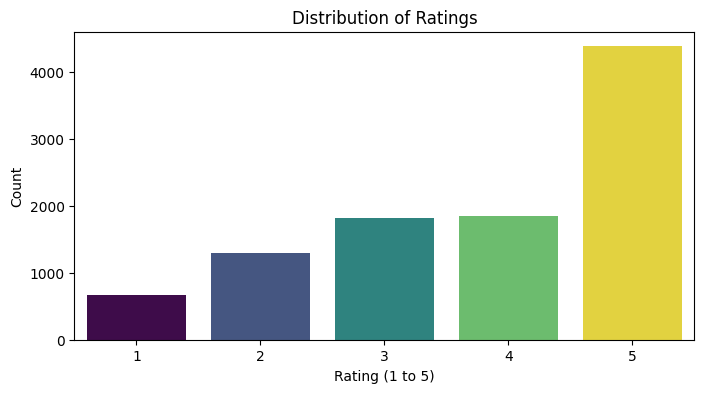

In [7]:
plt.figure(figsize=(8, 4))
sns.countplot(data=data, x="Rating", hue="Rating", palette="viridis", dodge=False, legend=False)
plt.title("Distribution of Ratings")
plt.xlabel("Rating (1 to 5)")
plt.ylabel("Count")
plt.show()

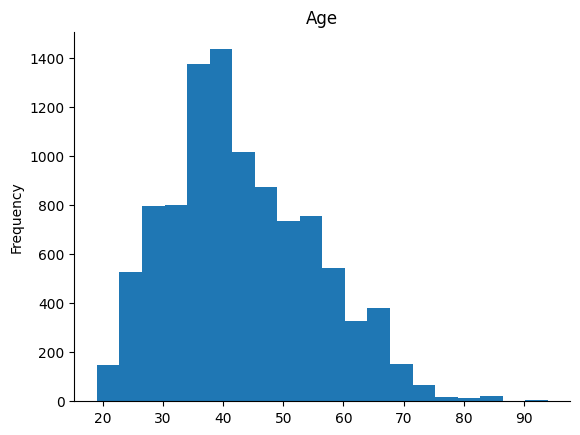

In [8]:
data['Age'].plot(kind='hist', bins=20, title='Age')
plt.gca().spines[['top', 'right',]].set_visible(False)

Prepare input-review texts and output-recommended IND for model to train.

In [9]:
review_texts = data["Review Text"].values
labels = data["Recommended IND"].values
rates = data["Rating"].values.astype(np.float32)
rates = rates / 5
print(f"Rates preview: {rates[:5]}")
data[["Review Text", "Recommended IND", "Rating"]].head()


Rates preview: [1.  1.  1.  0.8 1. ]


,Review Text,Recommended IND,Rating
0,a great little dress that can be dressed up or...,1,5
1,i found this in store last weekend and thought...,1,5
2,i bought one of these as a gift for a friend a...,1,5
3,"i love this tunic, the detail the weight, the ...",1,4
4,i got this in the color listed as pink. it is ...,1,5


Split training and Testing Sets

In [10]:
# x_train, x_test, y_train, y_test = train_test_split(review_texts, labels, test_size=0.2, random_state=19)
x_train, x_test, y_train, y_test, rates_train, rates_test = train_test_split(
    review_texts, labels, rates, test_size=0.2, random_state=19)
print(f"x_train shape: {len(x_train)}")
print(f"x_test shape: {len(x_test)}")
print(f"y_train shape: {len(y_train)}")
print(f"y_test shape: {len(y_test)}")
print(f"rates_train shape: {len(rates_train)}")
print(f"rates_test shape: {len(rates_test)}")

x_train shape: 8000
x_test shape: 2000
y_train shape: 8000
y_test shape: 2000
rates_train shape: 8000
rates_test shape: 2000


Extract the vocabulary list and assign indexes to the words, where the first and second positions are reserved for PAD and UNK, PAD is used to populate the text to a fixed length during model training and UNK is used for unknown words

In [11]:
def build_index(texts):
    counter = Counter()
    for text in texts:
        tokens = word_tokenize(text.lower())
        counter.update(tokens)
    word_dict = {word: idx + 2 for idx, (word, freq) in enumerate(counter.items()) if freq >= 1}
    word_dict = dict(word_dict)
    word_dict["<PAD>"] = 0
    word_dict["<UNK>"] = 1
    return word_dict

In [12]:
train_vocabulary = build_index(x_train)
print(list(train_vocabulary.items())[:10]) # Check vocabulary and their indexes
print(f"{train_vocabulary['<PAD>']}") # Check index for "PAD"
print(f"{train_vocabulary['<UNK>']}") # Check index for "UNK"

[('i', 2), ('first', 3), ('saw', 4), ('this', 5), ('vest', 6), ('displayed', 7), ('in', 8), ('the', 9), ('window', 10), ('and', 11)]
0
1


Encode the text for training, which means to converts words in the text to their corresponding indexes in the vocabulary.

In [13]:
# Encode the text for training
def encode(text, vocab):
    tokens = word_tokenize(text.lower())
    encoded_tokens = [vocab.get(token, vocab["<UNK>"]) for token in tokens] # If the word can not be found in vocabulary, get the index for "UNK"
    return encoded_tokens
x_train_encoded = [encode(text, train_vocabulary) for text in x_train]
x_test_encoded = [encode(text, train_vocabulary) for text in x_test]
print(x_train_encoded[:2])
print(x_test_encoded[:2])

[[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 9, 13, 11, 14, 15, 2, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 2, 26, 27, 28, 29, 30, 31, 32, 27, 33, 27, 34, 19, 15, 19, 35, 36, 11, 37, 38, 15, 39, 40, 41, 42, 11, 43, 15, 2, 44, 19, 45, 46, 22, 47, 48, 49, 15], [2, 50, 51, 5, 52, 35, 53, 54, 55, 56, 57, 41, 58, 59, 60, 61, 11, 2, 50, 51, 62, 63, 27, 64, 22, 65, 38, 15, 2, 51, 9, 66, 21, 9, 67, 29, 68, 69, 19, 70, 71, 50, 51, 2, 72, 73, 74, 41, 75, 76, 71, 8, 9, 77, 78, 79, 24, 11, 19, 35, 9, 80, 81, 82, 67, 78, 9, 79, 15, 2, 83, 59, 9, 84, 85, 35, 86, 87, 88, 59, 5, 16, 46, 89, 90, 78, 82, 91, 15, 9, 92, 60, 80, 78, 9, 93, 21, 5, 67, 24, 11, 2, 94, 17]]
[[2, 137, 95, 138, 8, 9, 1086, 459, 11, 368, 8, 83, 15, 62, 1, 1095, 11, 60, 1291, 336, 745, 276, 1008, 15, 2, 72, 255, 11, 2921, 295, 15, 11, 9, 869, 29, 798, 24, 2, 1723, 64, 122, 15, 711, 24, 2, 134, 17, 5569, 377, 753, 161, 25, 45, 271, 22, 811, 138, 377, 8, 1754, 62, 147, 138, 418, 15], [95, 60, 597, 80, 15, 9, 111, 669, 258, 24, 11, 19, 35, 

In [14]:
# class ReviewsDataset(Dataset):
#     def __init__(self, reviews, labels):
#         self.reviews = reviews
#         self.labels = labels

#     def __len__(self):
#         return len(self.reviews)

#     def __getitem__(self, idx):
#         review = self.reviews[idx]
#         label = self.labels[idx]
#         return torch.tensor(review), torch.tensor(label)
class ReviewsDataset(Dataset):
    def __init__(self, reviews, labels, rates):
        self.reviews = reviews
        self.labels = labels
        self.rates = rates

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):
        review = self.reviews[idx]
        label = self.labels[idx]
        rate = self.rates[idx]

        review_tensor = torch.tensor(review, dtype=torch.long)
        label_tensor = torch.tensor(label, dtype=torch.float32)
        rate_tensor = torch.tensor(rate, dtype=torch.float32)
        return review_tensor, label_tensor, rate_tensor

def collate_fn(batch):
    reviews, labels, rates = zip(*batch)
    reviews_padded = pad_sequence(reviews, batch_first=True, padding_value=0)
    labels_tensor = torch.tensor(labels)
    rates_tensor = torch.tensor(rates)
    return reviews_padded, labels_tensor, rates_tensor

train_dataset = ReviewsDataset(x_train_encoded, y_train, rates_train)
test_dataset = ReviewsDataset(x_test_encoded, y_test, rates_test)
train_loader = DataLoader(train_dataset, batch_size=32, collate_fn=collate_fn, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, collate_fn=collate_fn, shuffle=False)

for reviews, labels, rates in train_loader:
    print("Reviews shape:", reviews.shape)  # [batch size, text sequence length]
    print("Labels shape:", labels.shape)    # [batch size]
    print("Rates shape:", rates.shape)      # [batch size]
    break

for reviews, labels, rates in test_loader:
    print("Reviews shape:", reviews.shape)  # [batch size, text sequence length]
    print("Labels shape:", labels.shape)    # [batch size]
    print("Rates shape:", rates.shape)      # [batch size]
    break

Reviews shape: torch.Size([32, 112])
Labels shape: torch.Size([32])
Rates shape: torch.Size([32])
Reviews shape: torch.Size([32, 111])
Labels shape: torch.Size([32])
Rates shape: torch.Size([32])


## GRU Model Construction

In [15]:
# class GRUModel(nn.Module):
#     def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, output_dim):
#         super(GRUModel, self).__init__()
#         self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=train_vocabulary["<PAD>"]) # train_vocalulary["<PAD"] = 0
#         self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True)
#         self.fc = nn.Linear(hidden_dim, output_dim)

#     def forward(self, x):
#         embedded = self.embedding(x)
#         output, hidden = self.gru(embedded)
#         hidden = hidden[-1, :, :]
#         out = self.fc(hidden)
#         return out

class GRUModelWithRate(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, output_dim):
        super(GRUModelWithRate, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=train_vocabulary["<PAD>"])  # train_vocalulary["<PAD"] = 0
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim + 1, output_dim)  # hidden_dim + 1 to include rate

    def forward(self, reviews, rates):
        embedded = self.embedding(reviews)
        _, hidden = self.gru(embedded)
        hidden = hidden[-1, :, :]

        # Add rate feature
        rates = rates.unsqueeze(1)  # Expand rate dimensions to [batch_size, 1]
        combined = torch.cat((hidden, rates), dim=1)  # Concatenate hidden state and rate feature [batch_size, hidden_dim + 1]

        out = self.fc(combined)
        return out

Define some parameter for training

In [16]:
vocab_size = len(train_vocabulary)
embedding_dim = 100
hidden_dim = 128
num_layers = 2
output_dim = 1 # 2-classification task
num_epochs = 18 # Can adjust here, still finding the optimal value

## Train

In [17]:
# model = GRUModel(vocab_size, embedding_dim, hidden_dim, num_layers, output_dim)

# # Loss and optimizer
# criterion = nn.BCEWithLogitsLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model = GRUModelWithRate(vocab_size, embedding_dim, hidden_dim, num_layers, output_dim)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Use google colab cuda to train
model.to(device)

train_losses = []
# for epoch in range(num_epochs):
#     losses = []
#     for reviews, labels in train_loader:
#         reviews, labels = reviews.to(device), labels.to(device).float().unsqueeze(1)
#         optimizer.zero_grad()
#         outputs = model(reviews)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
#         losses.append(loss.item())
#     avg_loss = sum(losses)/len(losses)
#     train_losses.append(avg_loss)
#     print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

for epoch in range(num_epochs):
    model.train()
    losses = []
    for reviews, labels, rates in train_loader:
        reviews, labels, rates = reviews.to(device), labels.to(device).float().unsqueeze(1), rates.to(device)
        optimizer.zero_grad()
        outputs = model(reviews, rates)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    avg_loss = sum(losses) / len(losses)
    train_losses.append(avg_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

Epoch [1/18], Loss: 0.6327
Epoch [2/18], Loss: 0.5716
Epoch [3/18], Loss: 0.4486
Epoch [4/18], Loss: 0.3130
Epoch [5/18], Loss: 0.2393
Epoch [6/18], Loss: 0.1836
Epoch [7/18], Loss: 0.1342
Epoch [8/18], Loss: 0.1011
Epoch [9/18], Loss: 0.0665
Epoch [10/18], Loss: 0.0445
Epoch [11/18], Loss: 0.0334
Epoch [12/18], Loss: 0.0295
Epoch [13/18], Loss: 0.0190
Epoch [14/18], Loss: 0.0185
Epoch [15/18], Loss: 0.0283
Epoch [16/18], Loss: 0.0098
Epoch [17/18], Loss: 0.0161
Epoch [18/18], Loss: 0.0156


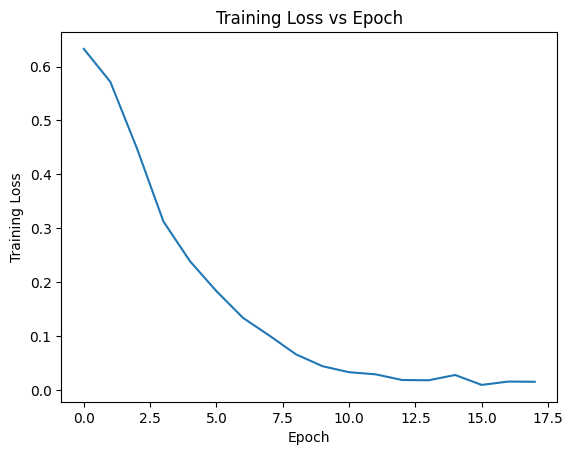

In [18]:
plt.plot(train_losses)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss vs Epoch")
plt.show()


## Evaluate


In [19]:
true_recommended = 0  # Correct predictions for "recommended" reviews
true_not_recommended = 0  # Correct predictions for "not recommended" reviews
total_recommended = 0  # Total number of "recommended" reviews
total_not_recommended = 0  # Total number of "not recommended" reviews

all_labels = []  # Store all ground truth labels
all_predictions = []  # Store all predicted results

with torch.no_grad():
    model.eval()
    for reviews, labels, rates in test_loader:
        reviews, labels, rates = reviews.to(device), labels.to(device).float().unsqueeze(1), rates.to(device)
        outputs = model(reviews, rates)
        predictions = (torch.sigmoid(outputs) > 0.5).int()
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predictions.cpu().numpy())
        true_recommended += ((predictions == 1) & (labels == 1)).sum().item()
        true_not_recommended += ((predictions == 0) & (labels == 0)).sum().item()
        total_recommended += (labels == 1).sum().item()
        total_not_recommended += (labels == 0).sum().item()

# Print evaluation results
print(f"Recommended - Predicted Correctly: {true_recommended}/{total_recommended}")
print(f"Not Recommended - Predicted Correctly: {true_not_recommended}/{total_not_recommended}")
precision = precision_score(all_labels, all_predictions)
recall = recall_score(all_labels, all_predictions)
accuracy = accuracy_score(all_labels, all_predictions)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Accuracy: {accuracy:.4f}")

Recommended - Predicted Correctly: 1183/1291
Not Recommended - Predicted Correctly: 505/709
Precision: 0.8529
Recall: 0.9163
Accuracy: 0.8440


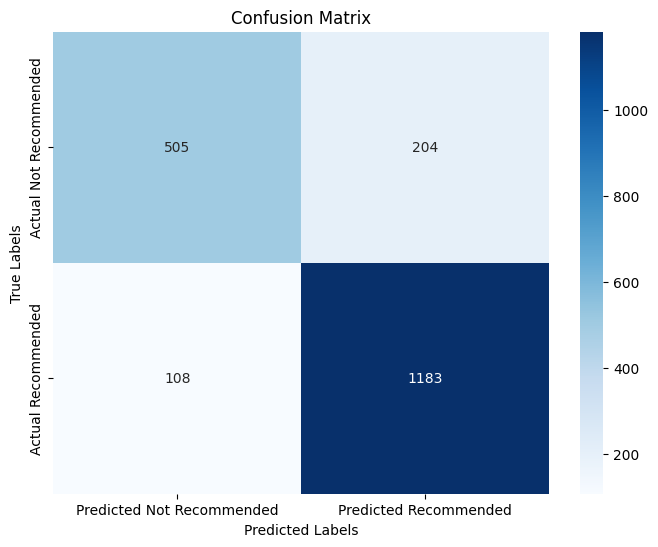

In [20]:
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Predicted Not Recommended", "Predicted Recommended"],
            yticklabels=["Actual Not Recommended", "Actual Recommended"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

Use a trained model to predict whether a given product review is classified as "Recommended" or "Not Recommended.

In [21]:
test_reviews = [
    # Recommended (Positive sentiment)
    "This product is amazing!",
    "I love this item, it's perfect for me.",
    "Absolutely fantastic quality, highly recommend.",
    "Good value for the price, exceeded my expectations.",
    "Pretty good, I’m satisfied with my purchase.",
    "Decent quality, works as advertised.",
    "It's okay, does the job but nothing special.",
    "Overall a good purchase, I would recommend it.",
    "The features are nice, better than I expected.",
    "I’m happy with this, great choice for the price.",

    # Not Recommended (Negative sentiment)
    "Terrible product, broke after one use.",
    "Awful quality, not worth the money.",
    "I’m disappointed, completely useless.",
    "Not great, feels cheap and flimsy.",
    "Would not recommend, didn’t meet my expectations.",
    "The quality is poor, I expected more.",
    "It’s acceptable but barely usable.",
    "Nothing special, very average at best.",
    "Doesn’t work as expected, quite frustrating.",
    "I regret buying this, waste of money.",
]
test_rates = [
    random.randint(4, 5) for _ in range(10)  # Rates for recommended (Positive sentiment)
] + [
    random.randint(0, 2) for _ in range(10)  # Rates for not recommended (Negative sentiment)
]
encoded_reviews = [torch.tensor(encode(review, train_vocabulary)).unsqueeze(0).to(device) for review in test_reviews]
rates = torch.tensor(test_rates).unsqueeze(1).to(device)

# Perform batch prediction
print("Predictions for Test Reviews:")
with torch.no_grad():
    for idx, (review_tensor, rate) in enumerate(zip(encoded_reviews, rates)):
        output = model(review_tensor, rate)
        probability = torch.sigmoid(output).item()
        prediction = int(probability > 0.5)

        # Print the result
        print(f"\nReview {idx+1}: {test_reviews[idx]}")
        print(f"Rate: {test_rates[idx]}")
        print(f"Predicted probability: {probability:.4f}")
        print(f"Predicted class (0: Not Recommended, 1: Recommended): {prediction}")



Predictions for Test Reviews:

Review 1: This product is amazing!
Rate: 4
Predicted probability: 0.9999
Predicted class (0: Not Recommended, 1: Recommended): 1

Review 2: I love this item, it's perfect for me.
Rate: 4
Predicted probability: 1.0000
Predicted class (0: Not Recommended, 1: Recommended): 1

Review 3: Absolutely fantastic quality, highly recommend.
Rate: 5
Predicted probability: 1.0000
Predicted class (0: Not Recommended, 1: Recommended): 1

Review 4: Good value for the price, exceeded my expectations.
Rate: 5
Predicted probability: 0.9995
Predicted class (0: Not Recommended, 1: Recommended): 1

Review 5: Pretty good, I’m satisfied with my purchase.
Rate: 4
Predicted probability: 0.9999
Predicted class (0: Not Recommended, 1: Recommended): 1

Review 6: Decent quality, works as advertised.
Rate: 5
Predicted probability: 1.0000
Predicted class (0: Not Recommended, 1: Recommended): 1

Review 7: It's okay, does the job but nothing special.
Rate: 4
Predicted probability: 0.9827


## Real Data Testcases


In [22]:
test_file_path = '/content/drive/MyDrive/684folder//20randomcases.csv'
real_test_data = pd.read_csv(test_file_path)
real_test_data_sorted = real_test_data.sort_values(by="Recommended IND", ascending=False)
real_test_data_sorted.head()

,Unnamed: 0,Age,Review Text,Rating,Recommended IND,Positive Feedback Count
0,0,42,always attracted to wool for its warmth and br...,5,1,15
3,3,23,i absolutely love this sweater. it is super so...,5,1,1
5,5,33,i love this dress! there are so many different...,5,1,0
4,4,30,i love this top so much that i ordered it in s...,5,1,0
16,16,31,expected them to fit somewhat loose but actual...,4,1,3


In [23]:
review_texts = real_test_data_sorted["Review Text"].values
rates = real_test_data_sorted["Rating"].values.astype(np.float32)
rates = torch.tensor(rates).unsqueeze(1).to(device)

encoded_reviews = [
    torch.tensor(encode(review, train_vocabulary)).unsqueeze(0).to(device) for review in review_texts
]

print("Predictions for Real Test Data:")
with torch.no_grad():
    for idx, (review_tensor, rate) in enumerate(zip(encoded_reviews, rates)):
        output = model(review_tensor, rate)
        probability = torch.sigmoid(output).item()
        prediction = int(probability > 0.5)

        print(f"\nReview {idx+1}: {review_texts[idx]}")
        print(f"Rate: {rate.item()}")
        print(f"Predicted probability: {probability:.4f}")
        print(f"Predicted class (0: Not Recommended, 1: Recommended): {prediction}")



Predictions for Real Test Data:

Review 1: always attracted to wool for its warmth and breathability. this jacket has great style that can be casual or dressed up some. it is slightly more boxy then expected which i think lends to the casual look. find myself wearing it a lot.
Rate: 5.0
Predicted probability: 1.0000
Predicted class (0: Not Recommended, 1: Recommended): 1

Review 2: i absolutely love this sweater. it is super soft and the greywhite version is lovely. it is definitely more cropped i am 57, but looks great with high waisted jeans or a pencil skirt. so cozy!
Rate: 5.0
Predicted probability: 1.0000
Predicted class (0: Not Recommended, 1: Recommended): 1

Review 3: i love this dress! there are so many different looks you can get just by adjusting the straps or shoulders. the material is lightweight and flows with every turn. i ordered my usual size 10 and it fits perfectly. i did need a little assistance in getting the side zip to go up, but once it was on i did not want to 